https://photutils.readthedocs.io/en/stable/aperture.html

In [1]:
#pip install photutils

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from scipy.spatial.distance import cdist
import scipy.signal as signal
from photutils.aperture import ApertureStats, CircularAperture, CircularAnnulus, EllipticalAperture, EllipticalAnnulus, aperture_photometry
from photutils.detection import DAOStarFinder, find_peaks, IRAFStarFinder
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astropy.table import Table
import cv2
import sys

from google.colab import drive
drive.mount('/content/drive')
sys.path.append('/content/drive/MyDrive/Bachelor')
from phot_used_functions_test import filter_sources, determine_distance, determine_shift, determine_magnitudes
from plottingFinal import show_image

ModuleNotFoundError: No module named 'google'

number of images: 10


Text(0.5, 1.0, '2023-09-26_HIP100587_defocused_B (Johnson)_4.0s_20_images_stacked_0')

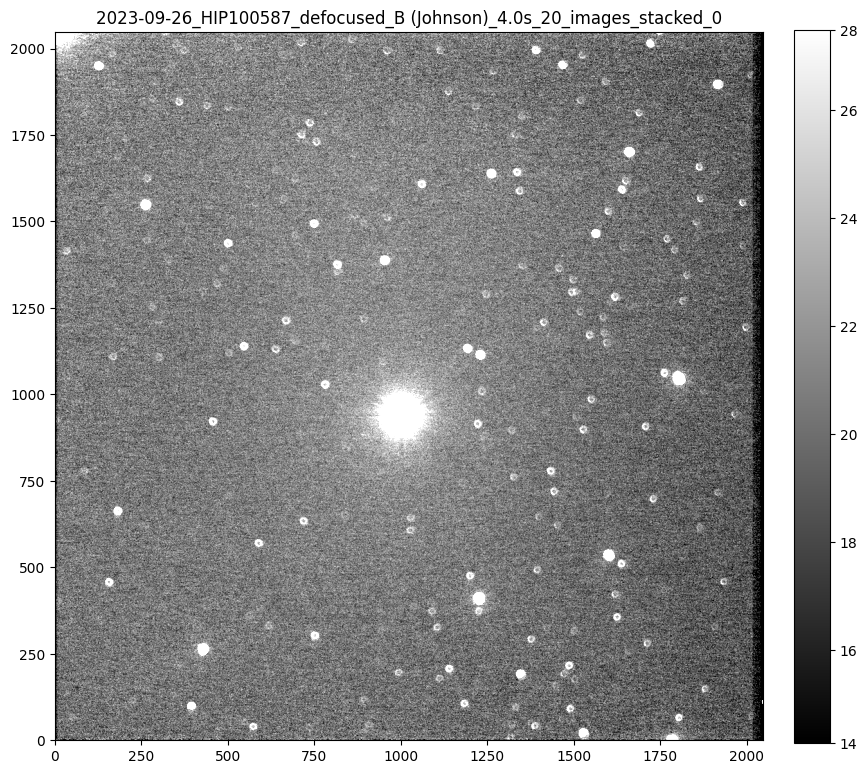

In [3]:
path= '/content/drive/MyDrive/Bachelor/data/2023-09-26/stacked/lightCor_HIP100587_defocused_B (Johnson)_4.0s_20_images_stacked_'

image_list = []
titles = []
for fits_path in glob.glob(os.path.join(path + '*fit')):
    with fits.open(fits_path) as hdul:
        image_list.append(hdul[0].data)
        exptime = hdul[0].header["EXPTIME"]
        titles.append(hdul[0].header['DATE-OBS'][:10] + os.path.splitext(os.path.basename(fits_path))[0][8:]) #date + filename

print("number of images:",len(image_list))
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
show_image(image_list[0], fig=fig, ax=ax)
ax.set_title(titles[0])

# 0. use normal image as reference picture

position of the bright star in focused image [[ 989.11598652 1017.30417089]]
detected stars in focused image: 158


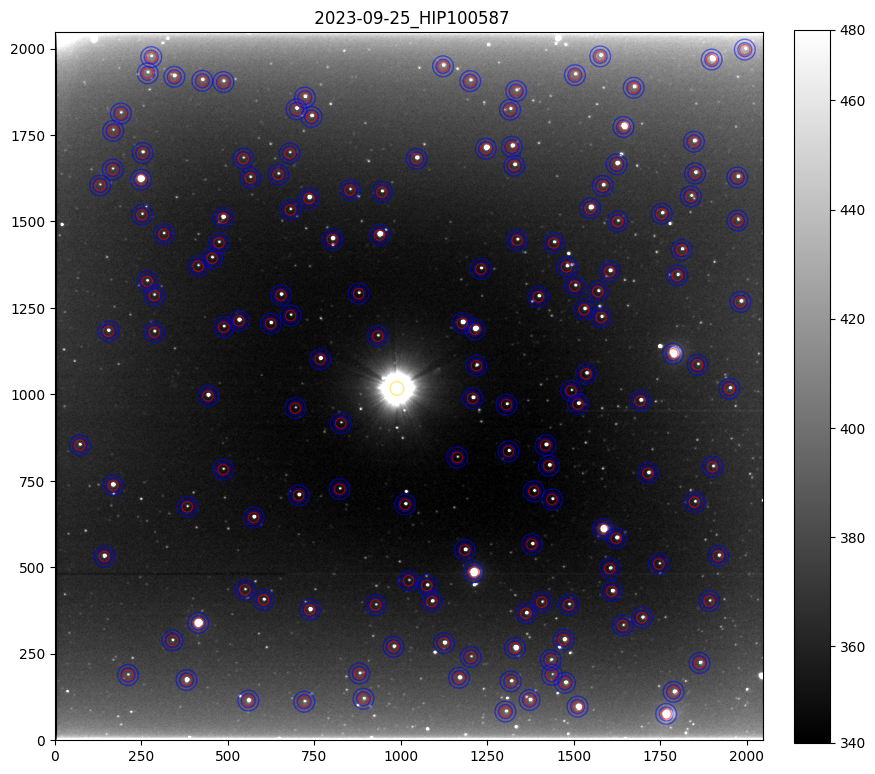

In [4]:
focused_path = "/content/drive/MyDrive/Bachelor/data/2023-09-25/stacked/lightCor_HIP100587_B (Johnson)_40.0s_long-short-series_10_images_stacked_0.fit"
#focused_path = "/content/drive/MyDrive/Bachelor/data/2023-08-23/lightCor/lightCor_R (Johnson)_30.0_0.fit"
#focused_path = '/content/drive/MyDrive/Bachelor/data/2023-09-11/stacked/lightCor_HIP100587_focused_B (Johnson)_40.0s_long_short_10_images_stacked_1.fit'
#focused_path = '/content/drive/MyDrive/Bachelor/data/2023-09-11/lightCor/lightCor_HIP100587_focused_R (Johnson)_1.0s_17.fit'
#focused_path = '/content/drive/MyDrive/Bachelor/data/2023-09-05/stacked/lightCor_HIP75458_H-alpha_40.0s_long_short_10_images_stacked_4.fit'
#focused_path = "/content/drive/MyDrive/Bachelor/data/2023-09-11/stacked/lightCor_HIP100587_focused_B (Johnson)_2.0s_long_short_10_images_stacked_2.fit"
#focused_path = "/content/drive/MyDrive/Bachelor/data/2023-09-11/stacked/lightCor_HIP100587_focused_B (Johnson)_40.0s_long_short_10_images_stacked_0.fit"
radius_bright = 100   # change here (choose larger: is only estimate)
center = [1000,1000]  # change here

hdul2 = fits.open(focused_path)
focused_image = hdul2[0].data
fig, ax = plt.subplots(1,1, figsize = (10,10))
show_image(focused_image, fig=fig, ax=ax)
ax.set_title(f" {hdul2[0].header['DATE-OBS'][:10]}_{hdul2[0].header['OBJECT']}")

# for bright star
mask = np.zeros(image_list[0].shape, dtype=bool)
x, y = np.ogrid[:focused_image.shape[1], :image_list[0].shape[0]]
circle_mask = np.sqrt((x - center[0]) ** 2 + (y - center[1]) ** 2) <= (radius_bright)
mask[circle_mask] = True
mask = ~mask

mean, median, std = sigma_clipped_stats(focused_image, sigma=3.0)
daofind_bright = DAOStarFinder(fwhm=10.0, threshold=5.0*std, roundlo=-5.0, roundhi=5.0, brightest=1) #roundlo and roundhi to adjust detection shape. need to be calibrated
sources_bright = daofind_bright(focused_image, mask = mask) #### or image-median? ???????????????????????????
sources_bright.sort(['xcentroid', 'ycentroid'])
position_bright_focused = np.transpose((sources_bright['xcentroid'], sources_bright['ycentroid']))
aperture_bright = CircularAperture(position_bright_focused, r=20)
aperture_bright.plot(color='gold', lw=1.0, alpha=0.5);
print("position of the bright star in focused image",position_bright_focused)

# for faint star
mask2 = np.zeros(focused_image.shape, dtype=bool)
circle_mask2 = np.sqrt((x - position_bright_focused[0][0]) ** 2 + (y - position_bright_focused[0][1]) ** 2) <= (radius_bright)
mask2[circle_mask2] = True
daofind_faint = DAOStarFinder(fwhm=3.0, threshold=5.0*std, roundlo=-5.0, roundhi=5.0) #roundlo and roundhi to adjust detection shape. need to be calibrated
sources_faint = daofind_faint(focused_image, mask=mask2)
sources_faint.sort(['xcentroid', 'ycentroid'])
positions_faint = np.transpose((sources_faint['xcentroid'], sources_faint['ycentroid']))
positions_faint,sources_faint = filter_sources(positions_faint, sources_faint, min_separation=40) #exclude multiple detections of star
print('detected stars in focused image:', len(positions_faint))
radius_faint = 15 #not relevant for later
apertures_faint = [CircularAperture(position, r=radius_faint) for position in positions_faint]
annulus_apertures_faint = [CircularAnnulus(position,r_in=radius_faint+5, r_out=radius_faint+15) for position in positions_faint]
for aperture in apertures_faint:
    aperture.plot(color="red", lw=1.0, alpha=0.5)
for anulus in annulus_apertures_faint:
    anulus.plot(color="blue", lw=1.0, alpha=0.5)

# 1. For bright Star (method: detect star on every image using starfinder)


In [5]:
mask = np.zeros(image_list[0].shape, dtype=bool)
mask[1900:2048, 0:200] = True

magnitude_list_bright = []
position_list_bright = []

for index, image in enumerate(image_list):
    mean, median, std = sigma_clipped_stats(image, sigma=3.0)
    #print((mean, median, std))
    daofind = DAOStarFinder(fwhm=3.0, threshold=5.0*std, roundlo=-1.0, roundhi=1.0,brightest=1) #roundlo and roundhi to adjust detection shape. need to be
    sources = daofind(image, mask=mask)
    positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
    positions,sources = filter_sources(positions, sources, 20)
    position_list_bright.extend(positions)

    radius_bright = 80
    aperture_bright = CircularAperture(positions, r=radius_bright)
    annulus_aperture_bright = CircularAnnulus(positions, r_in=radius_bright+15, r_out=radius_bright+40)

    fig, ax = plt.subplots(1,1, figsize= (10,10))
    show_image(image,fig=fig, ax=ax)
    ax.set_title(titles[index])
    aperture_bright.plot(color='red', lw=1.0, alpha=0.5);
    annulus_aperture_bright.plot(color="blue", lw=1.0, alpha=0.5);

    phot_table_bright = aperture_photometry(image, aperture_bright, method='subpixel', subpixels=5)
    aperstats = ApertureStats(image, annulus_aperture_bright)
    bkg = aperstats.median
    aperture_area = aperture_bright.area_overlap(image)
    total_bkg = bkg * aperture_area
    phot_table_bright['total_bkg'] = total_bkg

    for line in phot_table_bright:
      magnitude_bright = - (2.5*np.log10(abs(line[3]-line[4])/exptime)) #M = zeropoint - 2.5*log10((flux-background)/exptime)
    #phot_table_bright['magnitude'] = magnitude_bright
    #phot_table_bright.pprint(max_lines = -1, max_width = -1)
    magnitude_list_bright.append(magnitude_bright)
print('positions of bright star: ',position_list_bright)

print(np.std(magnitude_list_bright))

Output hidden; open in https://colab.research.google.com to view.

# 1.2 Bright star (method: determine position by hand and use shifts)


In [6]:
shifts_bright = determine_shift(image_list, wanted_index=0)
print(shifts_bright)

Number of images to process: 10
we use image:  0 from given list as reference image
[(0, 0), (-3.0189779, 0.01987989), (-3.074671, -0.20355132), (3.229749, 0.51627237), (29.627466, 0.6496924), (2.7909462, -0.6574909), (19.348219, 0.25235477), (11.720574, 0.03476395), (0.9255634, -0.2233672), (-4.247556, 0.5747399)]


In [7]:
magnitude_list_bright = []

valid_positions= [position_list_bright[0]] # define positon per hand

for i,image in enumerate (image_list):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    show_image(image, fig=fig, ax=ax)
    ax.set_title(titles[i])
    shifted_positions = []
    for position in valid_positions:
        tuple = np.array((position[0]+shifts_bright[i][0], position[1]+shifts_bright[i][1]))
        shifted_positions.append(tuple)

    radius_bright = 80
    aperture_bright = CircularAperture(shifted_positions, r=radius_bright)
    annulus_aperture_bright = CircularAnnulus(shifted_positions, r_in=radius_bright+15, r_out=radius_bright+45)
    aperture_bright.plot(color='red', lw=1.0, alpha=0.5);
    annulus_aperture_bright.plot(color="blue", lw=1.0, alpha=0.5);

    phot_table_bright = aperture_photometry(image, aperture_bright, method='subpixel', subpixels=5)
    aperstats = ApertureStats(image, annulus_aperture_bright)
    bkg = aperstats.median
    aperture_area = aperture_bright.area_overlap(image)
    total_bkg = bkg * aperture_area
    phot_table_bright['total_bkg'] = total_bkg

    for line in phot_table_bright:
      magnitude_bright = - (2.5*np.log10(abs(line[3]-line[4])/exptime)) #M = zeropoint - 2.5*log10((flux-background)/exptime)
    #phot_table_bright['magnitude'] = magnitude_bright
    #phot_table_bright.pprint(max_lines = -1, max_width = -1)
    magnitude_list_bright.append(magnitude_bright)

print(np.std(magnitude_list_bright))

Output hidden; open in https://colab.research.google.com to view.

# 2. Background stars

In [8]:
shifts = determine_shift(image_list, focused_image)
print(shifts)

#alternative way of determine shifts using dist. from bright stars of images
shifts2 = []
for position in position_list_bright:
    shift = (-position_bright_focused[0][0]+position[0], -position_bright_focused[0][1]+position[1])
    shifts2.append(shift)

print(shifts2)

Number of images to process: 10
[(10.195408, -78.358505), (7.4709587, -78.7178), (7.2939634, -78.4447), (13.678812, -78.3015), (39.638058, -77.47794), (12.959248, -78.99881), (29.65469, -78.37286), (22.158983, -78.50401), (11.341001, -78.61075), (5.991615, -78.00339)]
[(3.7011796607937413, -80.51379174595502), (2.2018662807432747, -81.90762888641348), (0.1403489562778759, -79.89808133502424), (8.704337835533124, -82.35264745210065), (35.37200850300201, -81.49859289191716), (5.79724654962763, -80.40624879619145), (23.33228059489295, -80.07766928810793), (17.697105151954588, -82.87962900368655), (4.3560004410182955, -80.8161071468619), (-0.21975468278901644, -80.06170498841493)]


In [9]:
radius=16 #change here

mask2 = np.zeros(focused_image.shape, dtype=bool)
x, y = np.ogrid[:focused_image.shape[1], :focused_image[0].shape[0]]
circle_mask = np.sqrt((x - position_bright_focused[0][0]) ** 2 + (y - position_bright_focused[0][1]) ** 2) <= (radius_bright+30)
mask2[circle_mask] = True

daofind_faint = DAOStarFinder(fwhm=3.0, threshold=5.0*std, roundlo=-5.0, roundhi=5.0, brightest=40) #roundlo and roundhi to adjust detection shape. need to be calibrated
sources_faint = daofind_faint(focused_image, mask=mask2)
sources_faint.sort(['xcentroid', 'ycentroid'])
positions_faint = np.transpose((sources_faint['xcentroid'], sources_faint['ycentroid']))
positions_faint,sources_faint = filter_sources(positions_faint, sources_faint, min_separation=40, min_edge_distance=60) #exclude multiple detections of star
print('detected stars in focused image:', len(positions_faint))

magnitude_list_faint = []

for i,image in enumerate (image_list):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    show_image(image, fig=fig, ax=ax)
    ax.set_title(titles[i])
    shifted_positions = []
    for position in positions_faint:
        tuple = np.array((position[0]+shifts[i][0], position[1]+shifts[i][1]))
        if 50 < tuple[0] < 2000 and 50 < tuple[1] < 2000: #use -50 of image size because later images shifting more
          shifted_positions.append(tuple)

    print('the valid shifted positions:', len(shifted_positions))
    apertures_faint = [CircularAperture(position, r=radius) for position in shifted_positions]
    annulus_apertures_faint = [CircularAnnulus(position,r_in=radius+5, r_out=radius+15) for position in shifted_positions]
    for aperture in apertures_faint:
        aperture.plot(color="red", lw=1.0, alpha=0.5)
    for anulus in annulus_apertures_faint:
        anulus.plot(color="blue", lw=1.0, alpha=0.5)

    # Initialize an empty table to store the photometry results
    phot_table_faint = Table(names=('id', 'xcenter', 'ycenter', 'aperture_sum', 'total_bkg'), dtype=('int', 'float', 'float', 'float', 'float'))
    for j in range(len(apertures_faint)):
        aperstats = ApertureStats(image, annulus_apertures_faint[j])
        bkg = aperstats.median
        aperture_area = apertures_faint[j].area_overlap(image)
        total_bkg = bkg * aperture_area
        phot_table = aperture_photometry(image, apertures_faint[j])
        phot_table['total_bkg'] = total_bkg
        phot_table_faint.add_row([j, phot_table['xcenter'][0], phot_table['ycenter'][0], phot_table['aperture_sum'][0], phot_table['total_bkg'][0]])
    #phot_table_faint.pprint(max_lines = -1, max_width = -1)

    magnitudes=[]
    for row in phot_table_faint:
        magnitude =  - (2.5 * np.log10(abs(row['aperture_sum'] - row['total_bkg']) / exptime))
        magnitudes.append(magnitude)
    magnitude_list_faint.append(magnitudes)


Output hidden; open in https://colab.research.google.com to view.

In [10]:
mean_magnitudes_list_faint = [np.mean(mag) for mag in magnitude_list_faint]
print(mean_magnitudes_list_faint)
print(np.std(mean_magnitudes_list_faint))

[-8.481421013140992, -8.464863289815678, -8.479998164015745, -8.469891047675622, -8.481256171911637, -8.464305631883008, -8.483625762635452, -8.484996000190108, -8.485318576789183, -8.480391581514814]
0.007684337434325531


# Diff Phot


In [22]:
diff_magnitude_list = []
for index in range (len(mean_magnitudes_list_faint)):
  diff_magnitude= magnitude_list_bright[index] - mean_magnitudes_list_faint [index]
  print(index,  magnitude_list_bright[index] , mean_magnitudes_list_faint [index], diff_magnitude)
  diff_magnitude_list.append(diff_magnitude)

print("")
print("The differential Magnitude of HIP100587 is: M = ", np.mean(diff_magnitude_list),"+-",np.std(diff_magnitude_list),"mag")
print(f"For bright star: {np.mean(magnitude_list_bright)}+-{np.std(magnitude_list_bright)}")
print(f"for faint stars: {np.mean(mean_magnitudes_list_faint)}+-{np.std(mean_magnitudes_list_faint)}")
print("")
print(round(np.mean(diff_magnitude_list),3), "err", round(np.std(diff_magnitude_list),3))
print(round(np.std(magnitude_list_bright),3), ",", round(np.std(mean_magnitudes_list_faint),3))

0 -15.469298513330429 -8.481421013140992 -6.9878775001894375
1 -15.471598124854575 -8.464863289815678 -7.0067348350388965
2 -15.471361577638366 -8.479998164015745 -6.99136341362262
3 -15.472422846341269 -8.469891047675622 -7.002531798665647
4 -15.467961484986464 -8.481256171911637 -6.986705313074827
5 -15.469877783110267 -8.464305631883008 -7.005572151227259
6 -15.47048782653808 -8.483625762635452 -6.9868620639026275
7 -15.468781538913738 -8.484996000190108 -6.98378553872363
8 -15.470177341310045 -8.485318576789183 -6.984858764520862
9 -15.47322988749575 -8.480391581514814 -6.992838305980936

The differential Magnitude of HIP100587 is: M =  -6.992912968494674 +- 0.008336138434536155 mag
For bright star: -15.470519692451898+-0.0015628847675205556
for faint stars: -8.477606723957225+-0.007684337434325531

-6.993 err 0.008
0.002 , 0.008


In [ ]:
x= np.linspace(0,(len(diff_magnitude_list))-1, len(diff_magnitude_list))
plt.errorbar(x, diff_magnitude_list, yerr= np.std(diff_magnitude_list), linestyle = "None", marker = ".",color="r", label = "measured differential magnitudes")
plt.axhline(np.mean(diff_magnitude_list), label= "mean" )
plt.xlabel("Picture number")
plt.ylabel("Differential Magnitudes")
plt.legend()

# try with function


In [19]:
import numpy as np
from astropy.stats import sigma_clipped_stats
from astropy.stats import mad_std
from photutils import CircularAperture, CircularAnnulus, aperture_photometry, ApertureStats
from astropy.table import Table


def determine_magnitudes(image, positions, star_radius, exptime):
  #for bright star
  if len(positions) == 1:
    aperture = CircularAperture(positions, r=star_radius)
    annulus_aperture = CircularAnnulus(positions, r_in=star_radius+15, r_out=star_radius+45)
    aperture.plot(color='red', lw=1.0, alpha=0.5);
    annulus_aperture.plot(color="blue", lw=1.0, alpha=0.5);
    phot_table = aperture_photometry(image, aperture, method='subpixel', subpixels=5)
    aperstats = ApertureStats(image, annulus_aperture)
    bkg = aperstats.median
    aperture_area = aperture.area_overlap(image)
    total_bkg = bkg * aperture_area
    phot_table['total_bkg'] = total_bkg
    for line in phot_table:
      magnitudes = - (2.5*np.log10(abs(line[3]-line[4])/exptime)) #here single value

  else:
    apertures = [CircularAperture(position, r=star_radius) for position in positions]
    annulus_apertures = [CircularAnnulus(position,r_in=star_radius+5, r_out=star_radius+15) for position in shifted_positions]
    for aperture in apertures:
        aperture.plot(color="red", lw=1.0, alpha=0.5)
    for anulus in annulus_apertures:
        anulus.plot(color="blue", lw=1.0, alpha=0.5)
    phot_table_faint = Table(names=('id', 'xcenter', 'ycenter', 'aperture_sum', 'total_bkg'), dtype=('int', 'float', 'float', 'float', 'float'))
    for j in range(len(apertures)):
        aperstats = ApertureStats(image, annulus_apertures[j])
        bkg = aperstats.median
        aperture_area = apertures[j].area_overlap(image)
        total_bkg = bkg * aperture_area
        phot_table = aperture_photometry(image, apertures[j])
        phot_table['total_bkg'] = total_bkg
        phot_table_faint.add_row([j, phot_table['xcenter'][0], phot_table['ycenter'][0], phot_table['aperture_sum'][0], phot_table['total_bkg'][0]])
    magnitudes=[]
    for row in phot_table_faint:
        magnitude =  - (2.5 * np.log10(abs(row['aperture_sum'] - row['total_bkg']) / exptime))
        magnitudes.append(magnitude) #magnitudes here list
  return magnitudes

In [20]:
mask2 = np.zeros(focused_image.shape, dtype=bool)
x, y = np.ogrid[:focused_image.shape[1], :focused_image[0].shape[0]]
circle_mask = np.sqrt((x - position_bright_focused[0][0]) ** 2 + (y - position_bright_focused[0][1]) ** 2) <= (radius_bright+30)
mask2[circle_mask] = True

daofind_faint = DAOStarFinder(fwhm=3.0, threshold=5.0*std, roundlo=-5.0, roundhi=5.0, brightest=40) #roundlo and roundhi to adjust detection shape. need to be calibrated
sources_faint = daofind_faint(focused_image, mask=mask2)
sources_faint.sort(['xcentroid', 'ycentroid'])
positions_faint = np.transpose((sources_faint['xcentroid'], sources_faint['ycentroid']))
positions_faint,sources_faint = filter_sources(positions_faint, sources_faint, min_separation=40, min_edge_distance=60) #exclude multiple detections of star
print('detected stars in focused image:', len(positions_faint))

magnitudes_list_faint = []
mean_magnitudes_list_faint=[]

for i,image in enumerate (image_list):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    show_image(image, fig=fig, ax=ax)
    ax.set_title(titles[i])
    shifted_positions = []
    for position in positions_faint:
        tuple = np.array((position[0]+shifts[i][0], position[1]+shifts[i][1]))
        if 50 < tuple[0] < 2000 and 50 < tuple[1] < 2000: #use -50 of image size because later images shifting more
          shifted_positions.append(tuple)

    print('the valid shifted positions:', len(shifted_positions))
    magnitudes = determine_magnitudes(image, positions=shifted_positions, star_radius=16, exptime=exptime)
    magnitudes_list_faint.append(magnitudes)

mean_magnitudes_list_faint = [np.mean(mag) for mag in magnitudes_list_faint]

print("mag=", np.mean(mean_magnitudes_list_faint),"+-",np.std(mean_magnitudes_list_faint))

Output hidden; open in https://colab.research.google.com to view.

In [21]:
mask = np.zeros(image_list[0].shape, dtype=bool)
mask[1900:2048, 0:200] = True

magnitude_list_bright = []
position_list_bright = []

for index, image in enumerate(image_list):
    mean, median, std = sigma_clipped_stats(image, sigma=3.0)
    #print((mean, median, std))
    daofind = DAOStarFinder(fwhm=3.0, threshold=5.0*std, roundlo=-1.0, roundhi=1.0,brightest=1) #roundlo and roundhi to adjust detection shape. need to be
    sources = daofind(image, mask=mask)
    positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
    positions,sources = filter_sources(positions, sources, 20)
    position_list_bright.extend(positions)
    fig, ax = plt.subplots(1,1, figsize= (10,10))
    show_image(image,fig=fig, ax=ax)
    ax.set_title(titles[index])
    magnitude_bright = determine_magnitudes(image, positions, star_radius=80, exptime=exptime)
    magnitude_list_bright.append(magnitude_bright)

print('positions of bright star: ',position_list_bright)
print(np.std(magnitude_list_bright))
print(magnitude_list_bright)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# function to determine individual radii
'''
def determine_distance(data, positions,max_value=30):
    valid_positions = []
    distance_list = []
    if len(positions) == 2: # if only one source
      x_values = [int(positions[0])]
      y_values = [int(positions[1])]
    else:
      x_values = [int(value[0]) for value in positions]
      y_values = [int(value[1]) for value in positions]

    #fig, ax = plt.subplots(len(positions), 1, figsize=(8, 6 * len(positions)))
    for i in range(len(x_values)):
        size = 40
        if x_values[i] < size or x_values[i] >= data.shape[1] - size:
            row_values = data[y_values[i], x_values[i] - x_values[i]: x_values[i] + x_values[i]]
        else:
            row_values = data[y_values[i], x_values[i] - size: x_values[i] + size]
        x_coordinates = range(len(row_values))
        row_values_bkg = row_values + np.median(row_values)  # add median as background
        peaks, _ = signal.find_peaks(row_values, distance=5)
        peak_values = [(row_values[peak], peak) for peak in peaks]
        sorted_peak_values = sorted(peak_values, reverse=True)
        top_two_values = sorted_peak_values[:2] #(y1,x1),(y2,x2)
        print(top_two_values)
        distance = np.abs(top_two_values[0][1]- top_two_values[1][1])
        #ax[i].plot(x_coordinates, row_values)
        #ax[i].scatter(top_two_values[0][1], top_two_values[0][0])
        #ax[i].scatter(top_two_values[1][1], top_two_values[1][0])
        if distance <= max_value and distance > 0:
            distance_list.append(distance)
            if len(positions) == 2:
                valid_positions.append(positions)
            else:
                valid_positions.append(positions[i])

    return distance_list, valid_positions
'''

'''
def filter_sources(positions, sources, min_separation=30.0, min_edge_distance=50.0):
    distances = cdist(positions, positions)
    edge_distance_x = np.minimum(positions[:, 0], 2048 - positions[:, 0])
    edge_distance_y = np.minimum(positions[:, 1], 2048 - positions[:, 1])
    keep_sources = np.ones(len(positions), dtype=bool)

    for i in range(len(positions)):
        if keep_sources[i]:
            # Find all detections within the minimum separation
            close_indices = np.where(distances[i] < min_separation)[0]

            if len(close_indices) > 1 and edge_distance_x[i] > min_edge_distance and edge_distance_y[i] > min_edge_distance:
                # Calculate the centroid of the close detections
                centroid_x = np.mean(positions[close_indices, 0])
                centroid_y = np.mean(positions[close_indices, 1])

                # Calculate distances from close detections to centroid
                distances_to_centroid = np.sqrt((positions[close_indices, 0] - centroid_x)**2 + (positions[close_indices, 1] - centroid_y)**2)

                # Find the index of the source closest to the centroid
                closest_index = close_indices[np.argmin(distances_to_centroid)]

                # Mark all close detections for removal except the closest one
                keep_sources[close_indices] = False
                keep_sources[closest_index] = True

            if edge_distance_x[i] < min_edge_distance or edge_distance_y[i] < min_edge_distance:
                keep_sources[i] = False

    filtered_positions = positions[keep_sources]
    filtered_sources = sources[keep_sources]

    return filtered_positions, filtered_sources
'''